In [1]:
import pickle 
import json
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import torch

from mlflux.predictor import FluxANNs
from mlflux.ann import RealFluxDataset
from mlflux.eval import mse_r2_weighted, distribution_weighted, open_case, evaluate

%load_ext autoreload
%autoreload 3

### Metrics

In [2]:
def plot_loss (model, axes, caselabel, **kwargs):
    # If two_steps
    # ['MSELoss', 'lr', 't_mse', 't_r2', 'v_mse', 'v_r2']
    # ['LLLoss', 'lr', 't_mse', 't_r2', 't_LLLoss', 't_resmean', 't_resvar', 'v_mse', 'v_r2', 'v_LLLoss', 'v_resmean', 'v_resvar']
    
    q1 = model.log[0]['t_mse'] if model.config['two_steps'] else model.log['t_mse']
    q2 = model.log[0]['v_mse'] if model.config['two_steps'] else model.log['v_mse']
    axes[0,0].plot(q1, label=caselabel+' train', **kwargs)
    axes[0,0].plot(q2, label=caselabel+' test', **kwargs)
    
    q1 = model.log[1]['t_LLLoss'] if model.config['two_steps'] else model.log['t_LLLoss']
    q2 = model.log[1]['v_LLLoss'] if model.config['two_steps'] else model.log['v_LLLoss']
    axes[0,1].plot(q1, label=caselabel+' train', **kwargs)
    axes[0,1].plot(q2, label=caselabel+' test', **kwargs)
    
    q1 = model.log[0]['t_r2'] if model.config['two_steps'] else model.log['t_r2']
    q2 = model.log[0]['v_r2'] if model.config['two_steps'] else model.log['v_r2']       
    axes[1,0].plot(q1, label=caselabel+' train', **kwargs)
    axes[1,0].plot(q2, label=caselabel+' test', **kwargs)  
    
    q1 = np.array(model.log[1]['t_resvar'])**0.5 if model.config['two_steps'] else np.array(model.log['t_resvar'])**0.5
    q2 = np.array(model.log[1]['v_resvar'])**0.5 if model.config['two_steps'] else np.array(model.log['v_resvar'])**0.5       
    axes[1,1].plot(q1, label=caselabel+' train', **kwargs)
    axes[1,1].plot(q2, label=caselabel+' test', **kwargs)
    
    axes[0,0].set_xlabel(''); axes[0,0].set_ylabel('MSE'); 
    axes[0,1].set_xlabel(''); axes[0,1].set_ylabel('LLLoss');    
    axes[1,0].set_xlabel('Epochs'); axes[1,0].set_ylabel('R2');
    axes[1,1].set_xlabel('Epochs'); axes[1,1].set_ylabel('Normalized std'); axes[1,1].legend()    

### Load ANNs

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


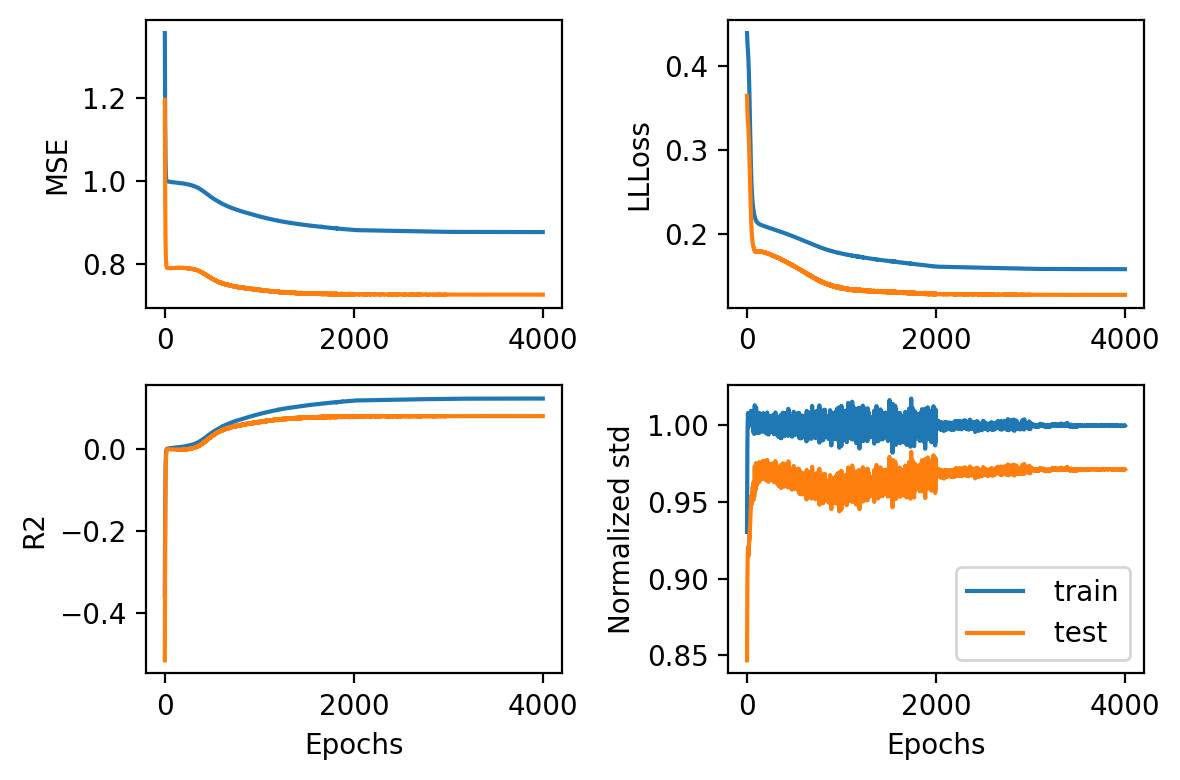

In [9]:
fig, axes = plt.subplots(2, 2, figsize=[6,4], dpi=200)

# model_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
# model_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
# model_dir = f'/scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/Mcross5_1/NW_tr2/'
model_name = 'model_rand4.p'    
model = open_case (model_dir, model_name)
caselabel = ''
plot_loss (model, axes, caselabel)

plt.tight_layout();
# plt.savefig(f'../../plots/loss.png', bbox_inches='tight')

### Old case

In [49]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff  

class Fluxdiff(FluxANNs):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  

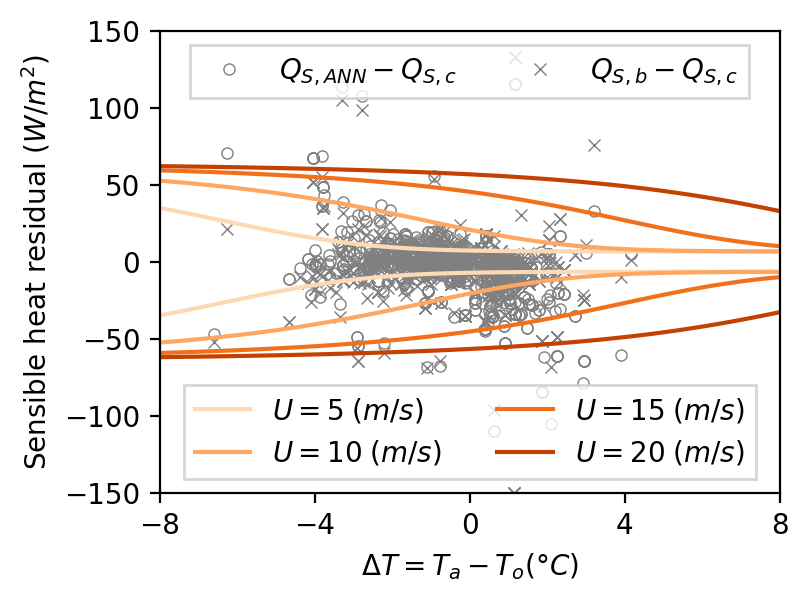

In [207]:
fig = plt.figure(figsize=[4,3], dpi=200); ax = plt.gca()
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
vd = RealFluxDataset(ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

model_dir = '/home/jw8736/mlflux/saved_model/one_output_anns/'
filename = model_dir + 'Flux41_sensible_3layers_split2.p' 
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)    
    Ypred_mean = model.pred_mean(vd.X)  


##### Plot a subset (20%) of samples (re-sampled according to weights?)
# Not weighted
# plt.plot(vd.X[:,2]-vd.X[:,1], Ypred_mean.detach().numpy()-vd.Y.detach().numpy(), '.', markersize=1, label=r'$\tau_{ANN} - \tau_c$')
# plt.plot(vd.X[:,2]-vd.X[:,1], vd.Bulk-vd.Y, '.', markersize=1, label=r'$\tau_b - \tau_c$')
# weighted
w_index = np.random.choice(len(vd.X), 800, p=vd.W.squeeze()/vd.W.sum())
markerkwargs = {'linestyle': '', 'marker': 'o', 'mfc': 'none', 'mec': 'gray', 'markersize': 4, 'markeredgewidth': 0.5}
sc1, = plt.plot(vd.X[w_index,2]-vd.X[w_index,1], Ypred_mean.detach().numpy()[w_index]-vd.Y.detach().numpy()[w_index],
         label=r'$Q_{S,ANN} - Q_{S,c}$', **markerkwargs)
markerkwargs = {'linestyle': '', 'marker': 'x', 'mfc': 'none', 'mec': 'gray', 'markersize': 4, 'markeredgewidth': 0.5}
sc2, = plt.plot(vd.X[w_index,2]-vd.X[w_index,1], vd.Bulk[w_index]-vd.Y[w_index], 
         label=r'$Q_{S,b} - Q_{S,c}$', **markerkwargs)

Uw_values = (5,10,15,20)
colors = plt.get_cmap('Oranges')
lines = []
for Uw in Uw_values:
    U = np.ones([101,1]) * Uw
    Ta = np.linspace(2,18,101).reshape(-1,1)
    To = np.ones([101,1]) * 10
    RH = np.ones([101,1]) * 80
    X = np.hstack([U,To,Ta,RH]).astype('float32')
    
    std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
    
    # plt.fill_between(x=X[:,2]-X[:,1], y1=std_pred.flatten(), y2=-std_pred.flatten(), alpha=0.5, color='C1', 
    #                  label=r'$\pm\sigma_{ANN}$ (10, 10, 10+$\Delta T$, 80)')
    line, = plt.plot(X[:,2]-X[:,1], std_pred.flatten(), color=colors(Uw/25), label=f'$U={Uw} \; (m/s)$')
    plt.plot(X[:,2]-X[:,1], -std_pred.flatten(), color=colors(Uw/25))
    lines.append(line)

plt.xlabel(r'$\Delta T = T_a-T_o (\degree C)$')
plt.ylabel('Sensible heat residual $(W/m^2)$')
plt.ylim([-150,150]); plt.xlim([-8,8]); plt.xticks([-8,-4,0,4,8])

first_legend = ax.legend(handles=[sc1, sc2], loc='upper center', ncol=2, fancybox=False)
ax.add_artist(first_legend)
second_legend = ax.legend(handles=lines, loc='lower center', ncol=2, fancybox=False)



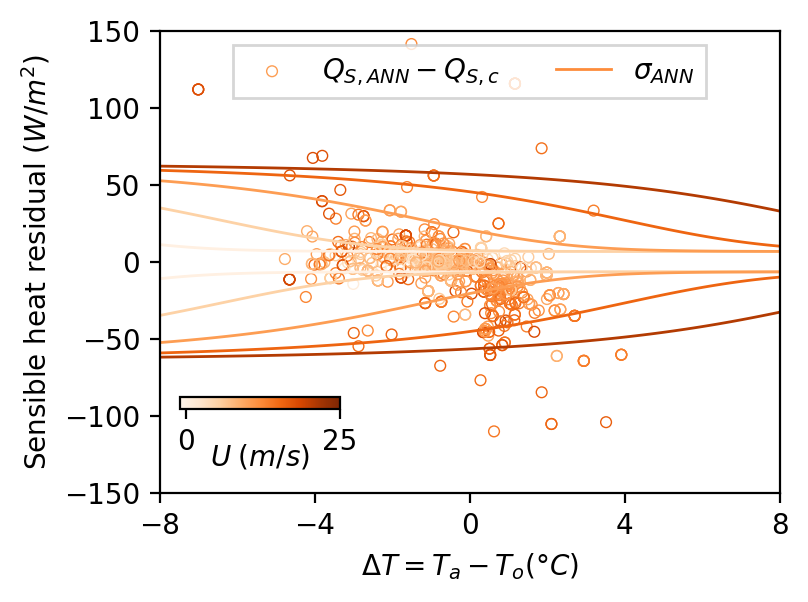

In [197]:
fig = plt.figure(figsize=[4,3], dpi=200)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
vd = RealFluxDataset(ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'])

model_dir = '/home/jw8736/mlflux/saved_model/one_output_anns/'
filename = model_dir + 'Flux41_sensible_3layers_split2.p' 
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)    
    Ypred_mean = model.pred_mean(vd.X)  

##### Plot a subset (20%) of samples (re-sampled according to weights?)
# Not weighted
# plt.plot(vd.X[:,2]-vd.X[:,1], Ypred_mean.detach().numpy()-vd.Y.detach().numpy(), '.', markersize=1, label=r'$\tau_{ANN} - \tau_c$')
# plt.plot(vd.X[:,2]-vd.X[:,1], vd.Bulk-vd.Y, '.', markersize=1, label=r'$\tau_b - \tau_c$')
# weighted
w_index = np.random.choice(len(vd.X), 800, p=vd.W.squeeze()/vd.W.sum())
# markerkwargs = {'linestyle': '', 'marker': 'o', 'mfc': 'none', 'mec': 'gray', 'markersize': 3, 'markeredgewidth': 0.5}
# plt.plot(vd.X[w_index,2]-vd.X[w_index,1], Ypred_mean.detach().numpy()[w_index]-vd.Y.detach().numpy()[w_index],
#          label=r'$Q_{S,ANN} - Q_{S,c}$', **markerkwargs)
# markerkwargs = {'linestyle': '', 'marker': 'x', 'mfc': 'none', 'mec': 'gray', 'markersize': 3, 'markeredgewidth': 0.5}
# plt.plot(vd.X[w_index,2]-vd.X[w_index,1], vd.Bulk[w_index]-vd.Y[w_index], 
#          label=r'$Q_{S,b} - Q_{S,c}$', **markerkwargs)

# Get RGBA color
edge_colors = plt.get_cmap('Oranges')((vd.X[w_index,0].squeeze()+1)/25)
markerkwargs = {'marker': 'o', 'facecolor': 'none', 's': 15, 'edgecolor': edge_colors, 'linewidth': 0.5}
plt.scatter(vd.X[w_index,2]-vd.X[w_index,1], Ypred_mean.detach().numpy()[w_index]-vd.Y.detach().numpy()[w_index],
            label=r'$Q_{S,ANN} - Q_{S,c}$', **markerkwargs)
# markerkwargs = {'marker': '^', 'facecolor': 'none', 's': 15, 'color': edge_colors, 'linewidth': 0.5}
# plt.scatter(vd.X[w_index,2]-vd.X[w_index,1], vd.Bulk[w_index]-vd.Y[w_index],
#             label=r'$Q_{S,b} - Q_{S,c}$', **markerkwargs)

Uw_values = (0,5,10,15,20)
colors = plt.get_cmap('Oranges')
for Uw in Uw_values:
    U = np.ones([101,1]) * Uw
    Ta = np.linspace(2,18,101).reshape(-1,1)
    To = np.ones([101,1]) * 10
    RH = np.ones([101,1]) * 80
    X = np.hstack([U,To,Ta,RH]).astype('float32')
    
    std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
    
    # plt.fill_between(x=X[:,2]-X[:,1], y1=std_pred.flatten(), y2=-std_pred.flatten(), alpha=0.5, color='C1', 
    #                  label=r'$\pm\sigma_{ANN}$ (10, 10, 10+$\Delta T$, 80)')
    plt.plot(X[:,2]-X[:,1], std_pred.flatten(), color=colors((Uw+1)/25), lw=1)
    plt.plot(X[:,2]-X[:,1], -std_pred.flatten(), color=colors((Uw+1)/25), lw=1)

plt.plot([], [], color=colors(0.5), label='$\sigma_{ANN}$', lw=1)

plt.xlabel(r'$\Delta T = T_a-T_o (\degree C)$')
plt.ylabel('Sensible heat residual $(W/m^2)$')
plt.ylim([-150,150]); plt.xlim([-8,8]); plt.xticks([-8,-4,0,4,8])
plt.legend(loc='upper center', ncols=2, fancybox=False)

import matplotlib as mpl
vmin = -1; vmax = 25
cbar_loc = [0.15,0.25,0.2,0.02]
cbar_label = '$U \; (m/s)$'
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)  # Set vmin/vmax to match the range of `i`
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm) # Create a ScalarMappable for the colorbar
sm.set_array([])  # Required to set an array for ScalarMappable
cbar_ax = fig.add_axes(cbar_loc)  
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(cbar_label, labelpad=-5)